In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

train = pd.read_csv("../dataset/original/train.csv")
test = pd.read_csv("../dataset/original/x_test.csv")

Here we define a function to convert the date form.

In [2]:
def convert_date(df):
    df['Unnamed: 0'] = df['Unnamed: 0'].str.split(" ")
    df['Unnamed: 0'] = df['Unnamed: 0'].apply(lambda x: "-".join(x[1:]))
    df = df.rename(columns={'Unnamed: 0':'Date'})
    df.Date = pd.to_datetime(df.Date)
    return df

In [3]:
df = pd.concat([train, test],sort=False)
df = convert_date(df)
df = df.sort_values(['sku','Date'])

# <b>Plot</b>

Separate train and test dataset.

In [4]:
train = df[~df.target.isna()]
test = df[df.target.isna()]

## Plotting some data

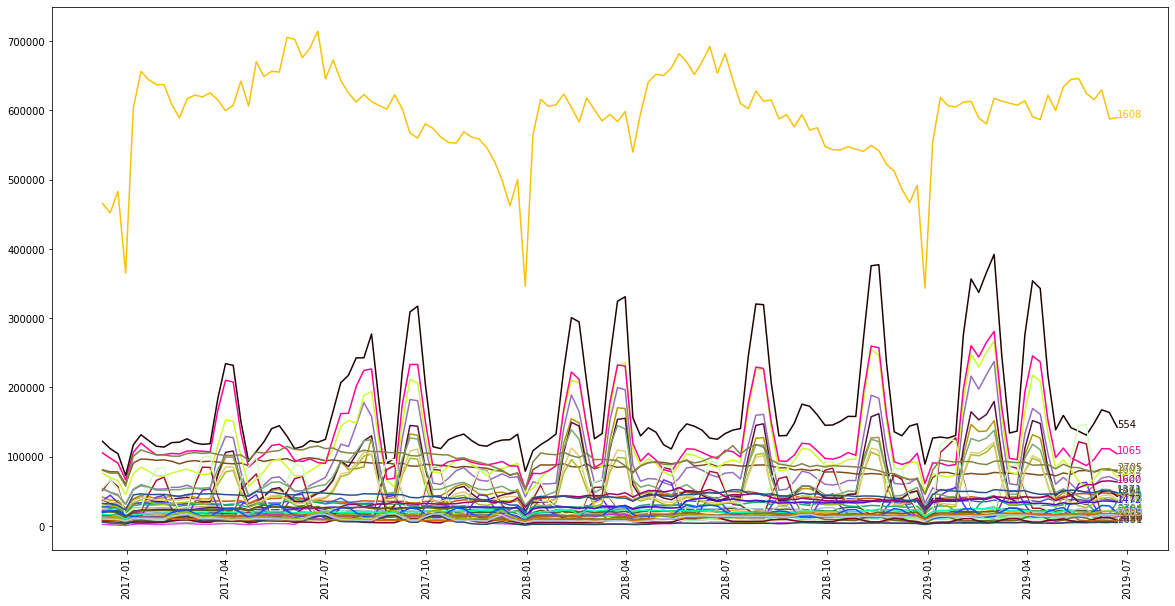

In [5]:
train = train.reset_index()

mycolors = np.random.choice(list(mpl.colors.XKCD_COLORS.keys()), len(set(df.sku)), replace=False)
plt.figure(figsize=(20,10))
plt.xticks(rotation=90)
for i, s in enumerate(set(train.sku)):
    plt.plot(train[train.sku==s].Date, train[train.sku==s].target,  color=mycolors[i])
    last_x, last_y = train[train.sku==s].Date.values[-1], train[train.sku==s].target.values[-1]
    plt.text(last_x, last_y, str(s), color=mycolors[i])

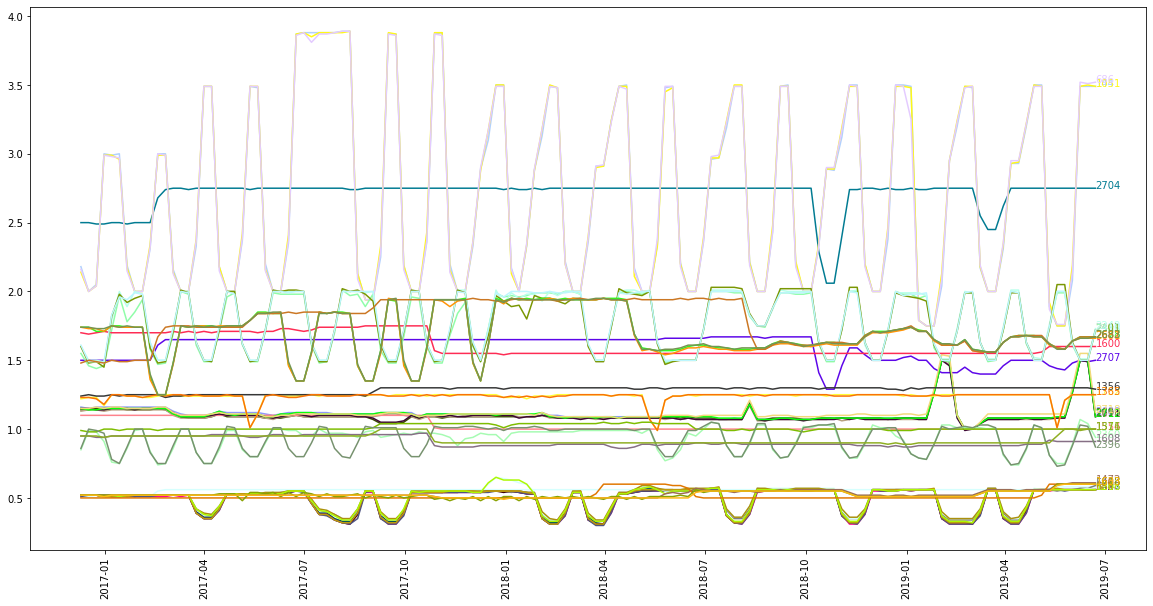

In [6]:
mycolors = np.random.choice(list(mpl.colors.XKCD_COLORS.keys()), len(set(df.sku)), replace=False)
plt.figure(figsize=(20,10))
plt.xticks(rotation=90)
for i, s in enumerate(set(train.sku)):
    plt.plot(train[train.sku==s].Date, train[train.sku==s]['price'],  color=mycolors[i])
    last_x, last_y = train[train.sku==s].Date.values[-1], train[train.sku==s]['price'].values[-1]
    plt.text(last_x, last_y, str(s), color=mycolors[i])

# <b>Hierarchical Clustering</b>

In [8]:
from scipy.spatial.distance import cdist, pdist
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from scipy import stats
from scipy.stats import pearsonr


In [9]:
series1=[]
for i, s in enumerate(set(train.sku)):
    series1.append(((train[train.sku==s].target).values))
series1=np.asarray(series1)
z1= linkage(series1,'single',metric='correlation')


The distance measure used for the clustering is the <i>correlation</i> between each pairs of series.

Then we plot the resulting dendogram.

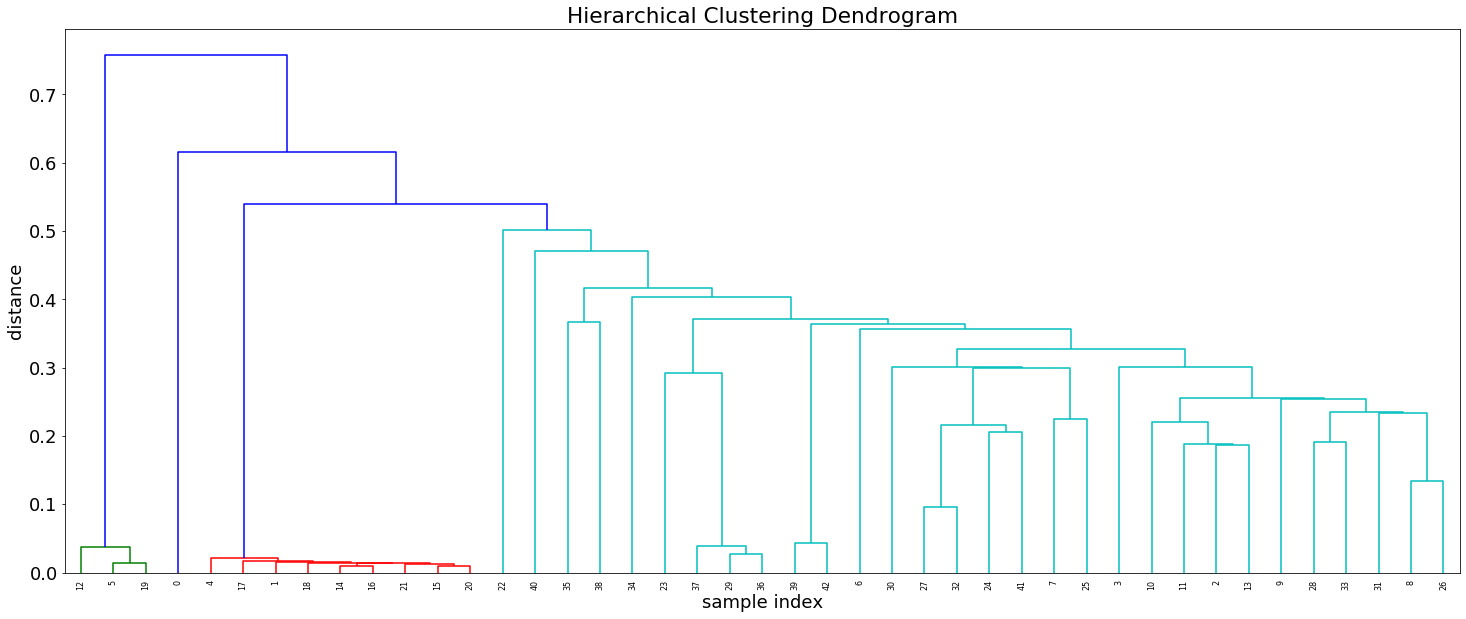

In [10]:
plt.figure(figsize=(25, 10))
font = {'family' : 'sans', 'size'   : 18}
plt.rc('font', **font)
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('sample index')
plt.ylabel('distance')
dendrogram(z1, 
    leaf_rotation=90.,  
    leaf_font_size=8.,  
)
plt.show()

# <b>Knee & Elbow Analysis</b>

In [11]:
wss_values = []
bss_values = []
k_values = range(1,20)

for k in k_values:
    clustering = fcluster(z1, k, criterion='maxclust')
    centroids = [np.mean(series1[clustering==c],axis=0) for c in range(1,k+1)]
    cdist(series1, centroids, 'correlation')
    D = cdist(series1, centroids,'correlation')
    cIdx = np.argmin(D,axis=1)
    d = np.min(D,axis=1)

    avgWithinSS = sum(d)/series1.shape[0]

    # Total with-in sum of square
    wss = sum(d**2)

    tss = sum(pdist(series1,metric='correlation')**2)/series1.shape[0]
    
    bss = tss-wss
    
    wss_values += [wss]
    bss_values += [bss]

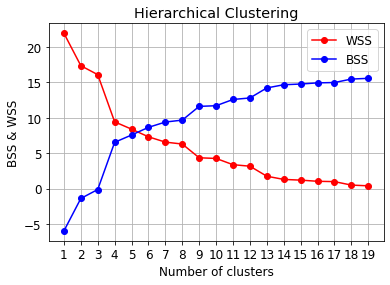

In [12]:
fig = plt.figure()
font = {'family' : 'sans', 'size'   : 12}
plt.rc('font', **font)
plt.plot(k_values, wss_values, 'bo-', color='red', label='WSS')
plt.plot(k_values, bss_values, 'bo-', color='blue', label='BSS')
plt.grid(True)
plt.xlabel('Number of clusters')
plt.ylabel('BSS & WSS')
plt.xticks(k_values)
plt.legend()
plt.title('Hierarchical Clustering');

There is an evident elbow at 4 so we put our evidence on what happens with 4 clusters. 

In [13]:
label_corr=fcluster(z1,4,criterion='maxclust') #Cluster with "correlation distance measure"
sku=list((set(train.sku)))

data={'Label': label_corr,
     'Sku':sku}
df_cluster=pd.DataFrame(data, columns=['Label','Sku'])



In [14]:
#Timeseries of 1st cluster
cluster1=df_cluster[df_cluster.Label==1].Sku
cluster1=np.asarray(cluster1)
#2 cluster
cluster2=df_cluster[df_cluster.Label==2].Sku
cluster2=np.asarray(cluster2)
#3 cluster
cluster3=df_cluster[df_cluster.Label==3].Sku
cluster3=np.asarray(cluster3)
#4 cluster
cluster4=df_cluster[df_cluster.Label==4].Sku
cluster4=np.asarray(cluster4)

cluster=[cluster1,cluster2,cluster3,cluster4]


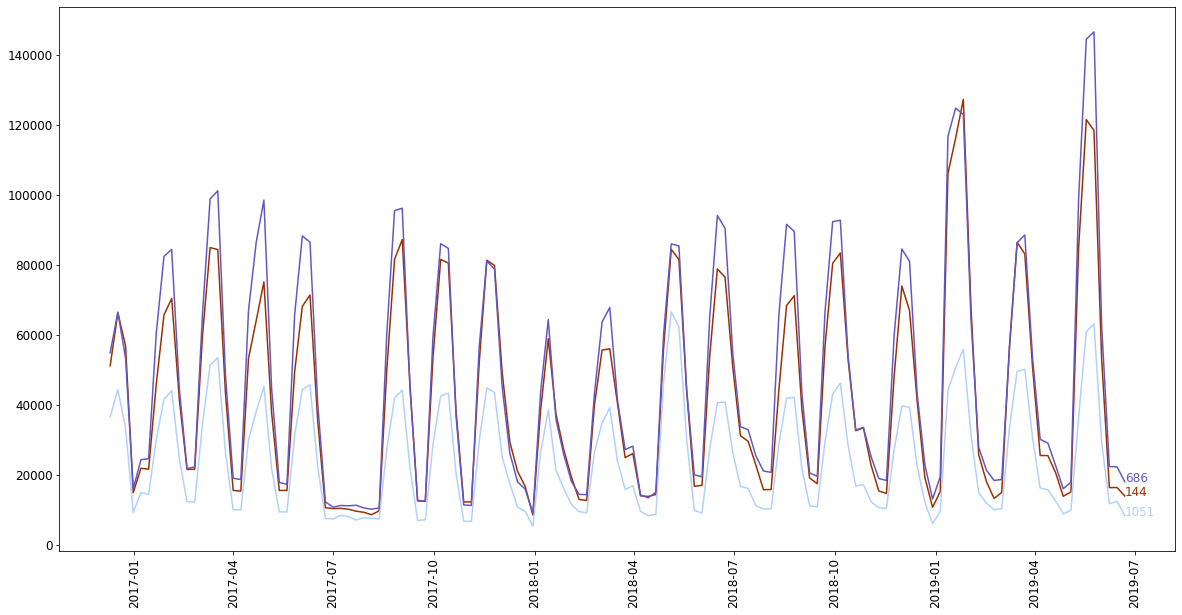

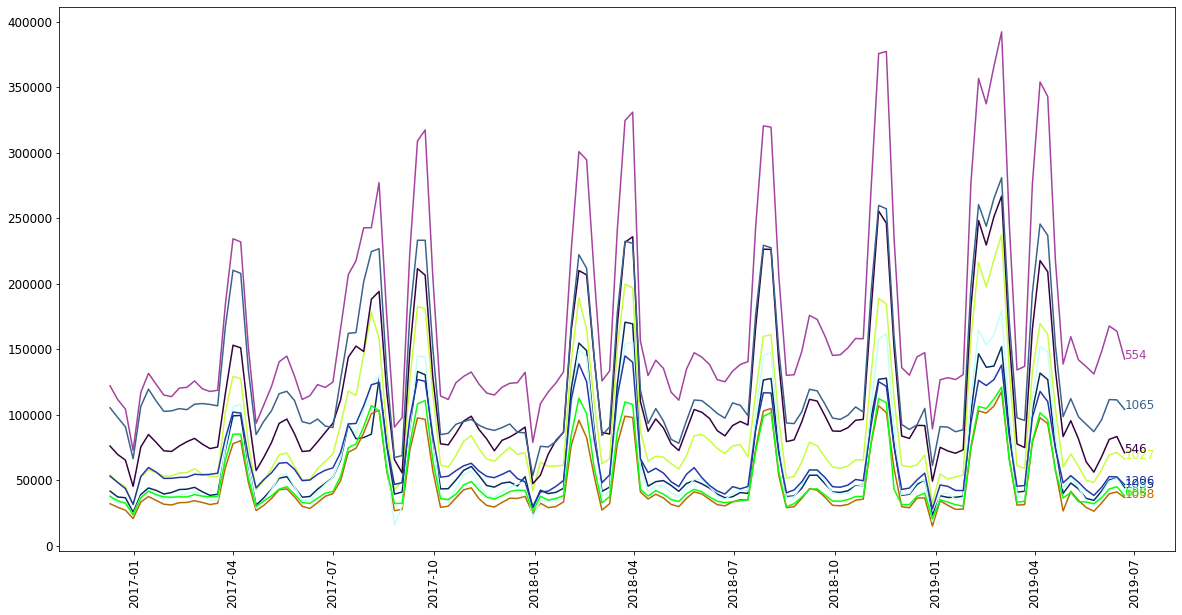

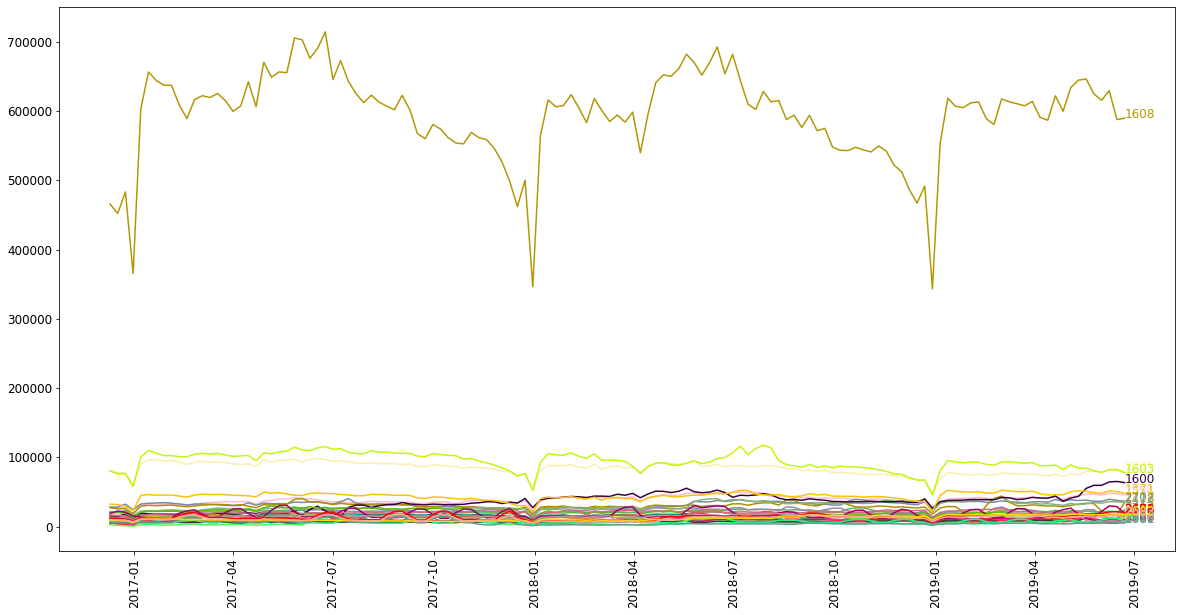

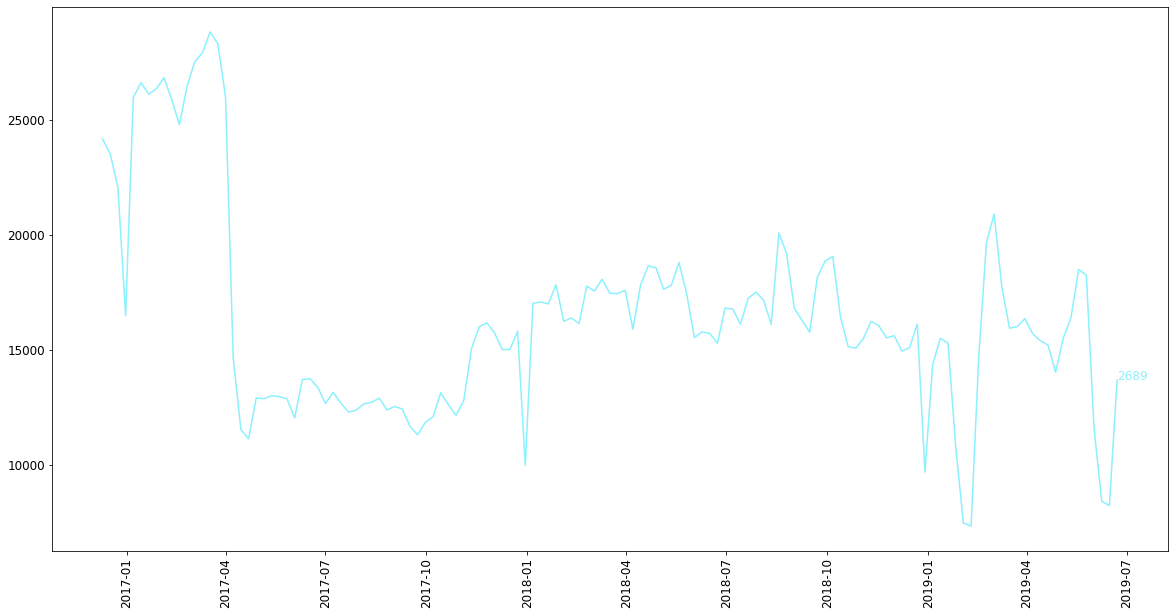

In [15]:
for j in cluster:
    
    mycolors = np.random.choice(list(mpl.colors.XKCD_COLORS.keys()), len(set(df.sku)), replace=False)
    plt.figure(figsize=(20,10))
    plt.xticks(rotation=90)
    for i in range(len(j)):
        plt.plot(train[train.sku==j[i]].Date, train[train.sku==j[i]].target,  color=mycolors[i])
        last_x, last_y = train[train.sku==j[i]].Date.values[-1], train[train.sku==j[i]].target.values[-1]
        plt.text(last_x, last_y, str(j[i]), color=mycolors[i])


We can notice that the last cluster is composed only by one element, so it might be labeled as outlier. 


# <b>2017/2018 Analysis</b>

In [16]:
train.set_index('Date',inplace=True)
tra_2017=train['2017-06-29':'2017-12-14']
tra_2018=train['2018-06-29':'2018-12-14']
tra_2017
a=test.sku

Tra_2017 is the training set only for the period from 14-12-2017 to 29-06-2017.
Tra_2018 is the same but for the year 2018.

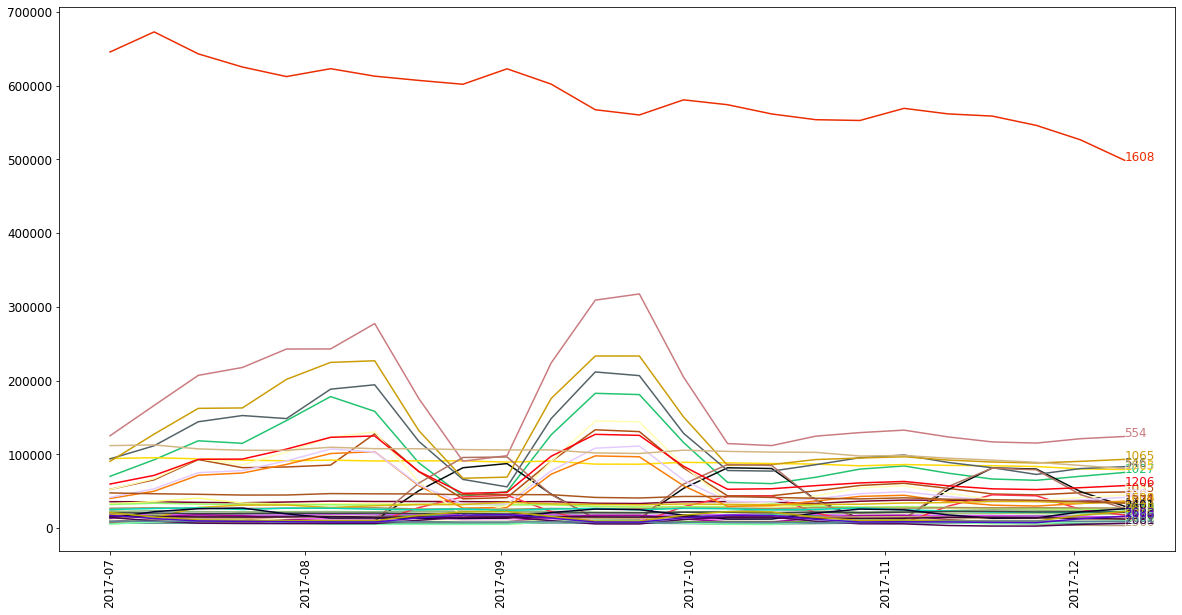

In [17]:
tra_2017 = tra_2017.reset_index()

mycolors = np.random.choice(list(mpl.colors.XKCD_COLORS.keys()), len(set(df.sku)), replace=False)
plt.figure(figsize=(20,10))
plt.xticks(rotation=90)
for i, s in enumerate(set(tra_2017.sku)):
    plt.plot(tra_2017[tra_2017.sku==s].Date, tra_2017[tra_2017.sku==s].target,  color=mycolors[i])
    last_x, last_y = tra_2017[tra_2017.sku==s].Date.values[-1], tra_2017[tra_2017.sku==s].target.values[-1]
    plt.text(last_x, last_y, str(s), color=mycolors[i])

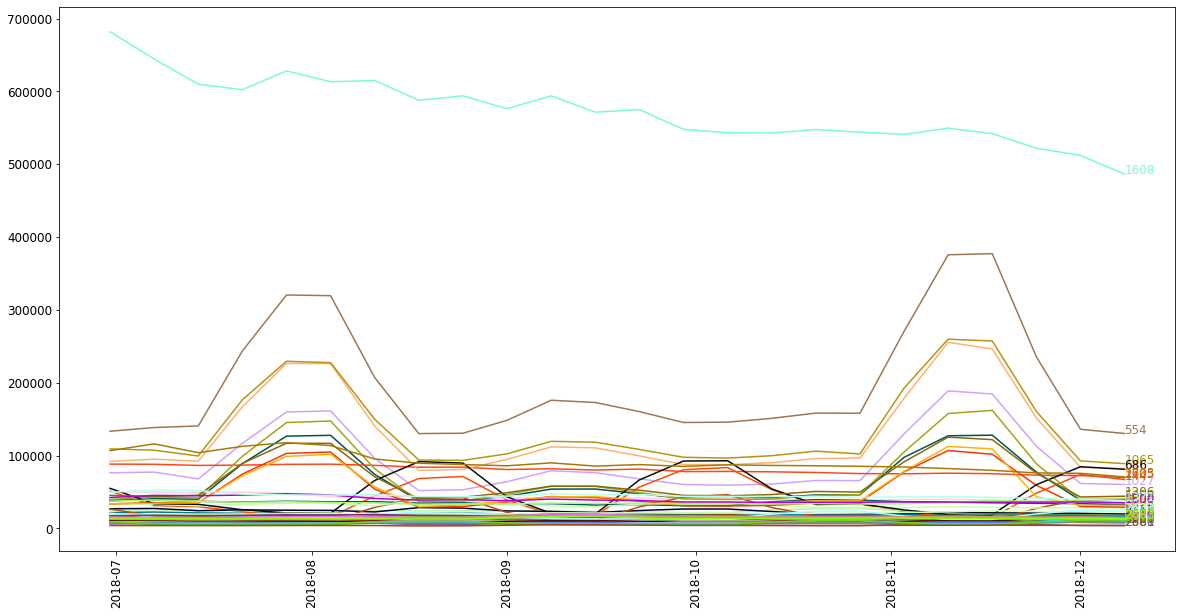

In [18]:
tra_2018 = tra_2018.reset_index()

mycolors = np.random.choice(list(mpl.colors.XKCD_COLORS.keys()), len(set(df.sku)), replace=False)
plt.figure(figsize=(20,10))
plt.xticks(rotation=90)
for i, s in enumerate(set(tra_2018.sku)):
    plt.plot(tra_2018[tra_2018.sku==s].Date, tra_2018[tra_2018.sku==s].target,  color=mycolors[i])
    last_x, last_y = tra_2018[tra_2018.sku==s].Date.values[-1], tra_2018[tra_2018.sku==s].target.values[-1]
    plt.text(last_x, last_y, str(s), color=mycolors[i])

# Cluster of 2017

In [22]:
ser=[]
for i, s in enumerate(set(tra_2017.sku)):
    ser.append(((tra_2017[tra_2017.sku==s].target).values))

ser=np.asarray(ser)

z_17= linkage(ser,'single',metric='correlation')
#print('z1 has %d rows'%(z1.shape[0]))


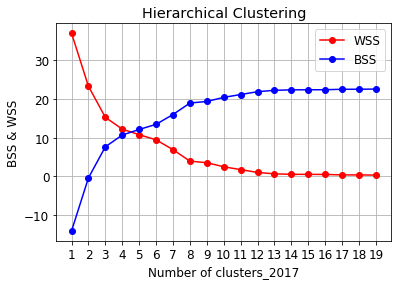

In [23]:
wss_values = []
bss_values = []
k_values = range(1,20)

for k in k_values:
    clustering = fcluster(z_17, k, criterion='maxclust')
    centroids = [np.mean(ser[clustering==c],axis=0) for c in range(1,k+1)]
    cdist(ser, centroids, 'correlation')
    D = cdist(ser, centroids,'correlation')
    cIdx = np.argmin(D,axis=1)
    d = np.min(D,axis=1)

    avgWithinSS = sum(d)/ser.shape[0]

    # Total with-in sum of square
    wss = sum(d**2)

    tss = sum(pdist(ser,metric='correlation')**2)/ser.shape[0]
    
    bss = tss-wss
    
    wss_values += [wss]
    bss_values += [bss]
fig = plt.figure()
font = {'family' : 'sans', 'size'   : 12}
plt.rc('font', **font)
plt.plot(k_values, wss_values, 'bo-', color='red', label='WSS')
plt.plot(k_values, bss_values, 'bo-', color='blue', label='BSS')
plt.grid(True)
plt.xlabel('Number of clusters_2017')
plt.ylabel('BSS & WSS')
plt.xticks(k_values)
plt.legend()
plt.title('Hierarchical Clustering');

# Cluster of 2018

In [20]:
ser1=[]
for i, s in enumerate(set(tra_2018.sku)):
    ser1.append(((tra_2018[tra_2018.sku==s].target).values))

ser1=np.asarray(ser1)

z_18= linkage(ser1,'single',metric='correlation')

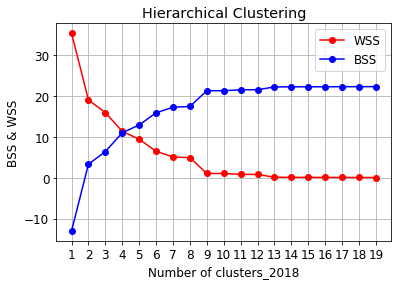

In [21]:
wss_values = []
bss_values = []
k_values = range(1,20)

for k in k_values:
    clustering = fcluster(z_18, k, criterion='maxclust')
    centroids = [np.mean(ser1[clustering==c],axis=0) for c in range(1,k+1)]
    cdist(ser1, centroids, 'correlation')
    D = cdist(ser1, centroids,'correlation')
    cIdx = np.argmin(D,axis=1)
    d = np.min(D,axis=1)

    avgWithinSS = sum(d)/ser1.shape[0]

    # Total with-in sum of square
    wss = sum(d**2)

    tss = sum(pdist(ser1,metric='correlation')**2)/ser1.shape[0]
    
    bss = tss-wss
    
    wss_values += [wss]
    bss_values += [bss]

fig = plt.figure()
font = {'family' : 'sans', 'size'   : 12}
plt.rc('font', **font)
plt.plot(k_values, wss_values, 'bo-', color='red', label='WSS')
plt.plot(k_values, bss_values, 'bo-', color='blue', label='BSS')
plt.grid(True)
plt.xlabel('Number of clusters_2018')
plt.ylabel('BSS & WSS')
plt.xticks(k_values)
plt.legend()
plt.title('Hierarchical Clustering');